# Cross Stitch Patterns from Images

This code will create a counted cross-stitch pattern from an image by pixellating it, determining color maps and replacing each pixel by an x in the designated color.  One can choose how many different colors to allow for a given image so that it is possible to minimize the complexity.  A color count of stitches will also be reported so the relative amounts of different color threads can be determined.

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


## Load image file

In [2]:
import scipy.ndimage as ndi
from scipy.misc import imresize
import requests
from StringIO import StringIO


In [3]:
response = requests.get("http://upload.wikimedia.org/wikipedia/commons/1/1c/CMS_Higgs-event.jpg")
pic = ndi.imread(StringIO(response.content))

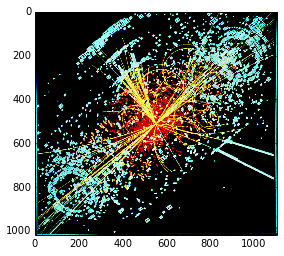

In [4]:
plt.imshow(pic);

In [5]:
print pic.shape
print pic[100,100]

(1018, 1104, 3)
[0 0 0]


Cross-stitching is done with a material called "Aida Cloth".  The size of the weave is measured by how many stitches can be made in one inch. This is called the fabric's count. The most common counts in Aida Cloth are 11, 14, 18 and 28. The higher the number, the smaller the stitches will be, because there are more stitches in each inch. 

For a 20 inch by 20 inch picture, using 14 count Aida Cloth, you have 280 stitches by 280 stitches.  

If you want to reproduce a picture pixel for pixel, divide the number of pixels in a given dimension by the fabric count for the Aida Cloth you intend to use.  That will show you how large the resulting pattern will be.  e.g. for the Higgs event shown above, with 28 count Aida cloth, the image will be 39 x 36 inches - 3 feet by 3 feet.  

In [6]:
#resize image
def resize(image,scale=25):
    """scale = % to resize.  This seems to also convert the 0-1 colors to integer RGB"""
    return imresize(image,scale,mode="RGB")

In [7]:
#count colors
def color_count(image):
    """Considering a (w,h,3) image of (dtype=ubyte),
    compute the number of unique colors\n"""
    F = image[...,0]*256*256 + image[...,1]*256 + image[...,2]
    unique, counts = np.unique(F, return_counts=True)
    return unique, counts

In [8]:
#Found an online RGB<-->DMC floss color conversion table to reference.
def load_floss_colors(example=True):
    values = np.loadtxt('DMCtoRGB_UK.txt', delimiter=' , ',dtype=int, usecols=[0,2,3,4])
    labels = np.loadtxt('DMCtoRGB_UK.txt', delimiter=' , ',dtype=str, usecols=[1,5])
    print "Example: ",values[27],labels[27]
    return values,labels

In [9]:
#Figure out how to convert hex string to integer for lookup.  The single float number method doesn't
#really work - widely disparate RGB numbers map to similar floats
#Try uint32 which can go from (0 to 4294967295)

def match_color(rgb):
    """for a given r,g,b tuple, determine the closest DMC thread color"""
    values,labels = load_floss_colors(False)
    #Compute distance to nearest color in RGB space
    rdiff2 = (rgb[0]-values[:,1])**2
    gdiff2 = (rgb[1]-values[:,2])**2
    bdiff2 = (rgb[2]-values[:,3])**2
    cdiff = np.sqrt(rdiff2+gdiff2+bdiff2)
    print "Input rgb: ",rgb
    print "Array location: ",cdiff.argmin()    
    print "Closest match: ",values[cdiff.argmin()],labels[cdiff.argmin()]
    return values[cdiff.argmin()],labels[cdiff.argmin()]

In [10]:
#list nearest floss colors with amounts for each
def floss_color_counts(image):
    unique, counts = color_count(image)
    for item in unique[0]:
        matchedval,matchedlab = match_color(item)
        print "Closest color = ",matchedval,matchedlab

In [11]:
def aida_size(pic,count=14):
    """Given an Aida cloth count and an image of a given number of pixels,
    report the size of the resulting pattern in inches"""
    x,y,col = pic.shape
    print "Pixel dimensions: (%d x %d)"%(x,y)
    print "Aida Cloth count: %d"%count
    print "Pattern dimensions: (%.2f in x %.2f in)"%(x/float(count),y/float(count))
    print "Pattern colors: %d"%(color_count(pic)[0]).size

In [21]:
def plot_before_after(before,after,text="Transformed"):
    cb = color_count(before)[0].size
    ca = color_count(after)[0].size
    # Two subplots, the axes array is 1-d
    f, axarr = plt.subplots(1,2,figsize=(12, 6))
    axarr[0].imshow(before)
    axarr[0].set_title('Original image (%d colors)'%cb)
    axarr[1].set_title('%s image (%d colors)'%(text,ca))
    axarr[1].imshow(after);

#First KMeans Algorithm 

In [24]:
#Scikit-learn provides a color reduction algorithm:
#http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html
    
# Authors: Robert Layton <robertlayton@gmail.com>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#
# License: BSD 3 clause
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from time import time

#reduce color count
def reduce_colors(image,n_color=16):
    # Convert to floats instead of the default 8 bits integer coding. Dividing by
    # 255 is important so that plt.imshow behaves works well on float data (need to
    # be in the range [0-1]
    clean = np.array(image, dtype=np.float64) / 255

    # Load Image and transform to a 2D numpy array.
    w, h, d = original_shape = tuple(clean.shape)
    assert d == 3
    image_array = np.reshape(clean, (w * h, d))
    
    #print "Fitting model on a small sub-sample of the data" 
    t0 = time()
    image_array_sample = shuffle(image_array, random_state=0)[:1000]
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
    #print "done in %0.3fs." % (time() - t0)
    
    # Get labels for all points
    #print "Predicting color indices on the full image (k-means)" 
    t0 = time()
    labels = kmeans.predict(image_array)
    #print "done in %0.3fs." % (time() - t0) 
    
    #Recreate the (compressed) image from the kmeans results & labels
    d = kmeans.cluster_centers_.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = kmeans.cluster_centers_[labels[label_idx]]
            label_idx += 1
    return image

# Second KMeans Algorithm

In [14]:
import scipy as sp
from scipy.cluster.vq import kmeans,vq

In [15]:
def perform_kmeans(image, k):
    '''Apply kmeans algorithm.
   Input:  image, number of clusters
   Output: centroids, vector with the index of the centroid assigned to each pixel, clusters'''
    rows, cols, rgb = image.shape
    # reshape the image in a single row array of RGB pixels
    image_row = np.reshape(image,(rows * cols, 3))
    # perform the clustering
    centroids,_ = kmeans(image_row, k)
    # vector quantization, assign to each pixel the index of the nearest centroid (k=1..4)
    qnt,_ = vq(image_row,centroids)
    # reshape the qnt vector to the original image shape
    image_centers_id = np.reshape(qnt,(rows, cols))
    # assign the centroid value to each pixel
    clustered = centroids[image_centers_id]
    return centroids, qnt, clustered

In [16]:
def predominant_color(centroids, counts):
    '''Select the most repetead color
   Input: centroids, vector with the number of occurrences for each color
   Output: most repetead centroid'''
    index_max = sp.argmax(counts)
    return centroids[index_max]

In [17]:
def count_colors(qnt, centroids):
    '''Count the number of pixels associated to each centroid
   Input: quantization vector, centroids
   Output: k length array with the count of pixels per centroid'''
    # count number of pixels on each cluster
    counts, bins = sp.histogram(qnt, len(centroids))
    return counts, bins

#Applied to Data 

## First algorithm

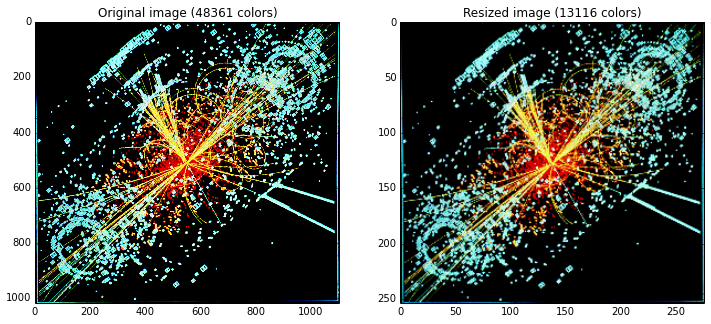

In [22]:
before = pic
after = resize(pic)
plot_before_after(before,after,"Resized")

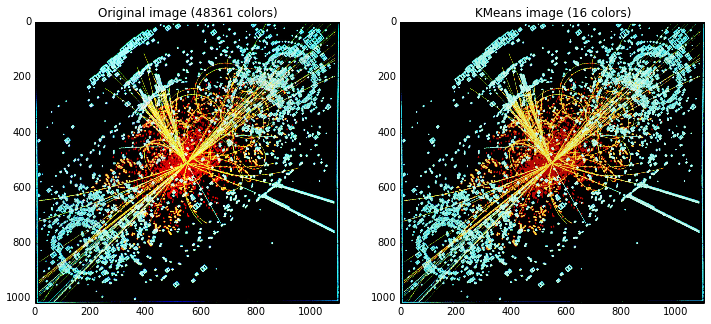

In [25]:
#Test color reduction on original image
n_colors= 16
newim = reduce_colors(before,n_colors)
plot_before_after(before,newim,"KMeans")
#unique, counts = color_count(newim)


#print newim[0,0],newim[125,125]
#1   8  20  33  47  47  78  95 120 133 151 198 203 210 225 236
#0  11  80  51 139 175 229   8 143 198 238   9  80 245 174 232
#0  42  90  14 122 192 227   3  34 148 230   5  25 226  58  82
#red = floor(unique/256.)
#blue = floor((unique - unique/256.)/256.)
#green = floor(fmod(blue,256))
#print "Unique red: ",red
#print "Unique blue: ",blue
#print "Unique green: ",floor(unique).astype(uint32)
#print "Color counts: ",counts

#Convert encoded unique colors to rgb values
#r,g,b = (unique>>16)&0x0ff, (unique>>8) &0x0ff, (unique)&0x0ff

#print "\tUnique red:",r
#print "\tUnique green:",g
#print "\tUnique blue:",b
#rgb = np.dstack((r,g,b))
#print rgb[0,2]
#print np.where(newim == rgb[0,2])[0][0],np.where(newim == rgb[0,2])[1][0]
#print newim[np.where(newim == rgb[0,2])[0][0],np.where(newim == rgb[0,2])[1][1]]

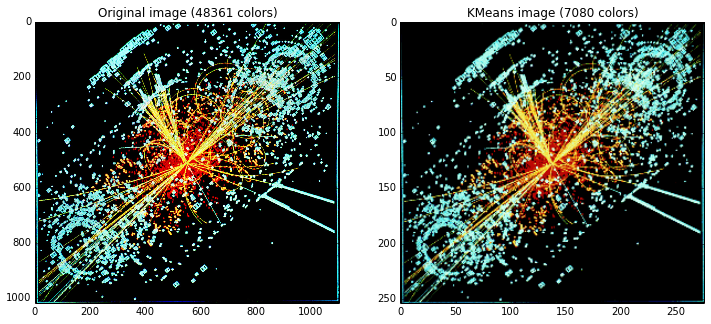

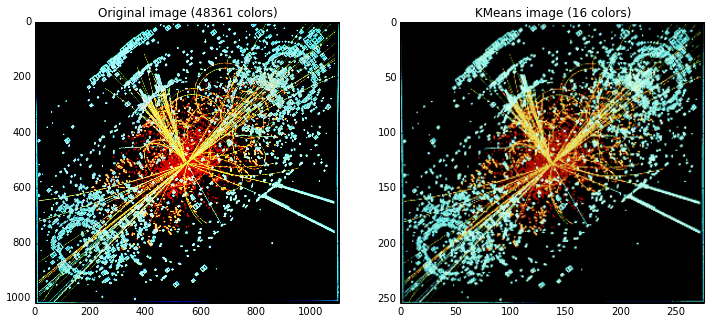

In [27]:
#Now reduce size of Kmeans image
smaller = resize(newim) #for some reason explodes the color space
plot_before_after(before,smaller,"KMeans")
smaller2 = reduce_colors(smaller,n_colors) #reduce the colors again
plot_before_after(before,smaller2,"KMeans")

In [31]:
#Now show the colors and counts
finalcount, density = color_count(smaller2)
print finalcount, density
#floss_color_counts(smaller2)

[  5.09685856e+01   1.65065144e+03   5.60740392e+03   8.44238968e+03
   1.35444532e+04   1.53411278e+04   1.59899457e+04   2.62811000e+04
   3.19548063e+04   3.28158910e+04   4.08681206e+04   4.42662963e+04
   5.11195673e+04   5.26613049e+04   5.67464855e+04   6.05120275e+04] [46442  1157  1233  1361  1602  1374  1208   636  2018   706  2602  1818
  1069  3521  1421  1936]


---

## Apply algorithm 2

In [723]:
centroids, qnt, clustered = perform_kmeans(before, 24)
counts, bins = count_colors(qnt, centroids)

In [724]:
print predominant_color(centroids, counts)

[0 0 0]


In [731]:
print centroids
print counts
print clustered.shape
print clustered[125,125]
match_color(clustered[125,125])
for color in centroids:
    match_color(color)
    print

[[ 78 223 220]
 [ 28 114 125]
 [  0   0   0]
 [217 225 133]
 [201 244 232]
 [ 42   9   4]
 [216 125  29]
 [232 217  62]
 [143 234 224]
 [  6  20  37]
 [128 141  50]
 [153  24   7]
 [ 46  84  31]
 [218  15   5]
 [ 92  16   7]
 [ 64 173 163]
 [  3   2   4]
 [ 11  55  83]]
[ 1619  1155 39777  1138  3615  1215  1106  1853  3727  1392   904   873
   918  1206   831  1369  6526   880]
(254, 276, 3)
[218  15   5]
Input rgb:  [218  15   5]
Array location:  234
[900 206  43   0] ['Burnt Orange - DK' '0xCE2B00']
Input rgb:  [ 78 223 220]
Array location:  433
[3846   82  173  234] ['Bright Turquoise - LT' '0x52ADEA']

Input rgb:  [ 28 114 125]
Array location:  389
[3809   31  107  123] ['Turquoise - VY DK' '0x1F6B7B']

Input rgb:  [0 0 0]
Array location:  49
[310   0   0   0] ['Black' '0x000000']

Input rgb:  [217 225 133]
Array location:  379
[3819  231  235  123] ['Moss Green - LT' '0xE7EB7B']

Input rgb:  [201 244 232]
Array location:  9
[162 202 231 240] ['Baby Blue - LT +++' '0xCBDCFD']

Inp

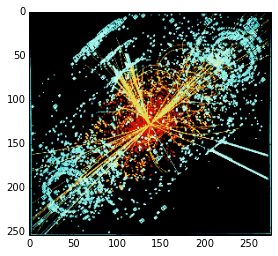

In [726]:
plt.imshow(clustered)

Now that I have reduced the number of pixels and the number of colors, I need to represent each color by an ascii character, then create a new 2d array with the character in each array element representing the color of that array element.